In [2]:
# Run this before the demo. This is indexing process. It stores vector embeddings in memory with FAISS.
import os
os.chdir("/app")
import faiss          # pip install faiss-cpu
import numpy as np
from pathlib import Path
from object_search import ObjectSearch



# 1. Initialise the helper ---------------------------------------------------
API_TOKEN = "a9a26987be374cdeb1d14cdf231b5215" # ⚠️  replace with your own bria.ai API token.
obj_search = ObjectSearch(API_TOKEN)

# 2. Gather all image paths ---------------------------------------------------
data_dir = Path.cwd() / "data"

# print file names in the data directory

img_paths = sorted(
    p for p in data_dir.glob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
)
if not img_paths:
    raise RuntimeError(f"No images found in {data_dir.absolute()}")

# 3. Run the pipeline & collect vectors --------------------------------------
vecs = []
id_to_path = []          # parallel list, idx ↔︎ file path

for i, path in enumerate(img_paths):
    print(f"[{i+1}/{len(img_paths)}] Processing {path.name}")
    vec = obj_search.pipeline(
        image_path=str(path),
        normalize_background=True,
        normalize_contrast=True,
        normalize_scale=True,
        output_intermediate_images=False,   # change if you want the steps
        model_name="dinov2_vits14",  # 384-D output
        mode="cpu",                        # or "gpu" if CUDA is available
    )
    vecs.append(vec)
    id_to_path.append(str(path))

# 4. Build FAISS index --------------------------------------------------------
vecs_np = np.stack(vecs).astype("float32")      # shape: (N, 384)
index = faiss.IndexFlatIP(vecs_np.shape[1])     # inner-product == cosine because unit-norm
index.add(vecs_np)                              # in-memory!

print(f"\n✅ Indexed {index.ntotal} images")



[1/6] Processing crosstrek1.png
🔄 Removing background...
🔄 Normalizing contrast...
🔄 Normalizing scale...
🔄 Generating vector embeddings...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


✅ Pipeline completed successfully!
[2/6] Processing crosstrek2.png
🔄 Removing background...
🔄 Normalizing contrast...
🔄 Normalizing scale...
🔄 Generating vector embeddings...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✅ Pipeline completed successfully!
[3/6] Processing crosstrek3.png
🔄 Removing background...
🔄 Normalizing contrast...
🔄 Normalizing scale...
🔄 Generating vector embeddings...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✅ Pipeline completed successfully!
[4/6] Processing crosstrek4.png
🔄 Removing background...
🔄 Normalizing contrast...
🔄 Normalizing scale...
🔄 Generating vector embeddings...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✅ Pipeline completed successfully!
[5/6] Processing outback1.jpeg
🔄 Removing background...
🔄 Normalizing contrast...
🔄 Normalizing scale...
🔄 Generating vector embeddings...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✅ Pipeline completed successfully!
[6/6] Processing outback2.jpeg
🔄 Removing background...
🔄 Normalizing contrast...
🔄 Normalizing scale...
🔄 Generating vector embeddings...
✅ Pipeline completed successfully!

✅ Indexed 6 images


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Text(value='./data/outback1.jpeg', description='Image file name:', layout=Layout(width='80%'), placeholder='En…

Button(description='🔍 Search', style=ButtonStyle())


Top matches:


'→ /app/data/outback1.jpeg  (score 1.0000)'

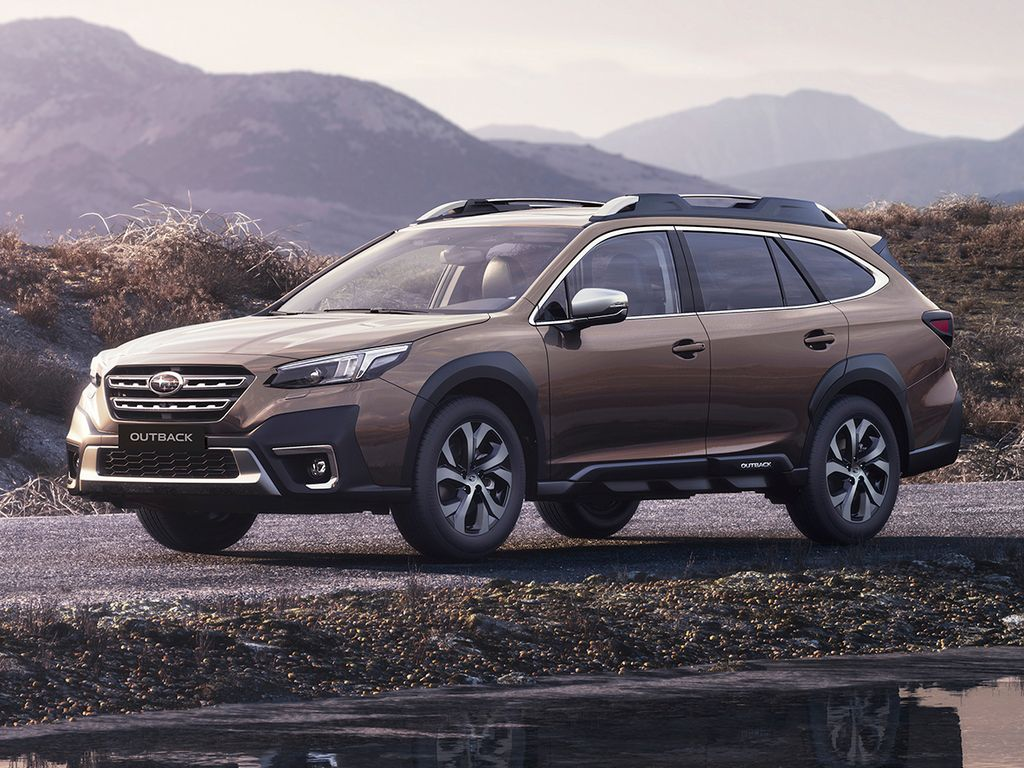

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score 0.9476)'

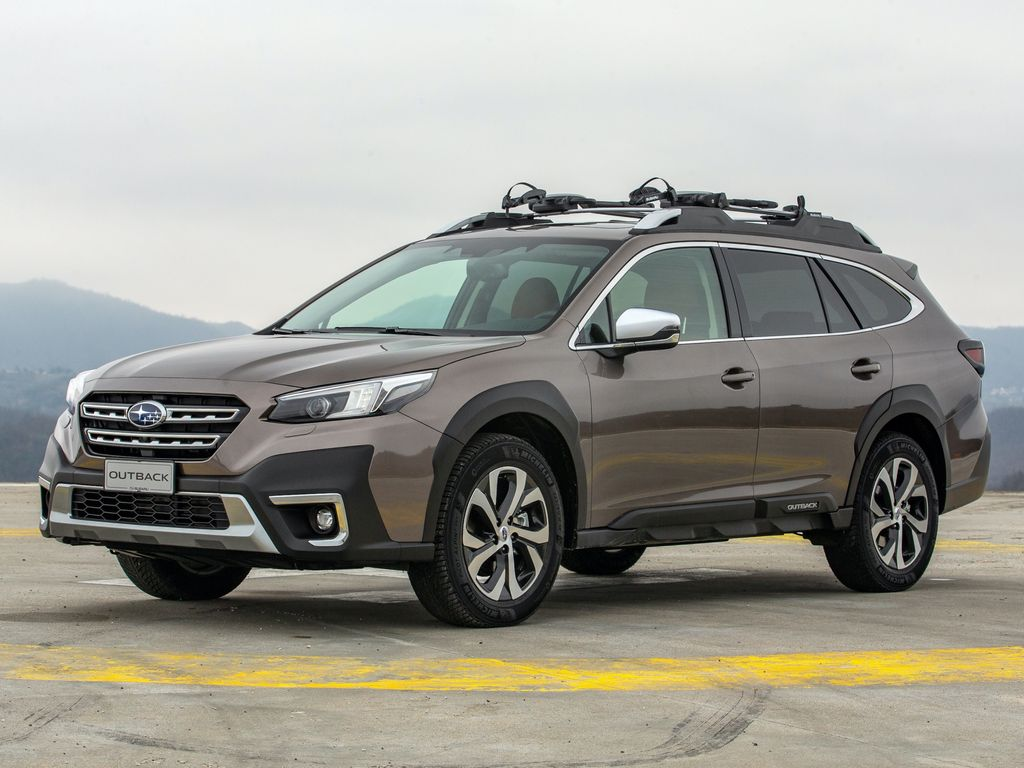

'------------------------------------------------------------------------------------------'

'→ /app/data/crosstrek3.png  (score 0.9358)'

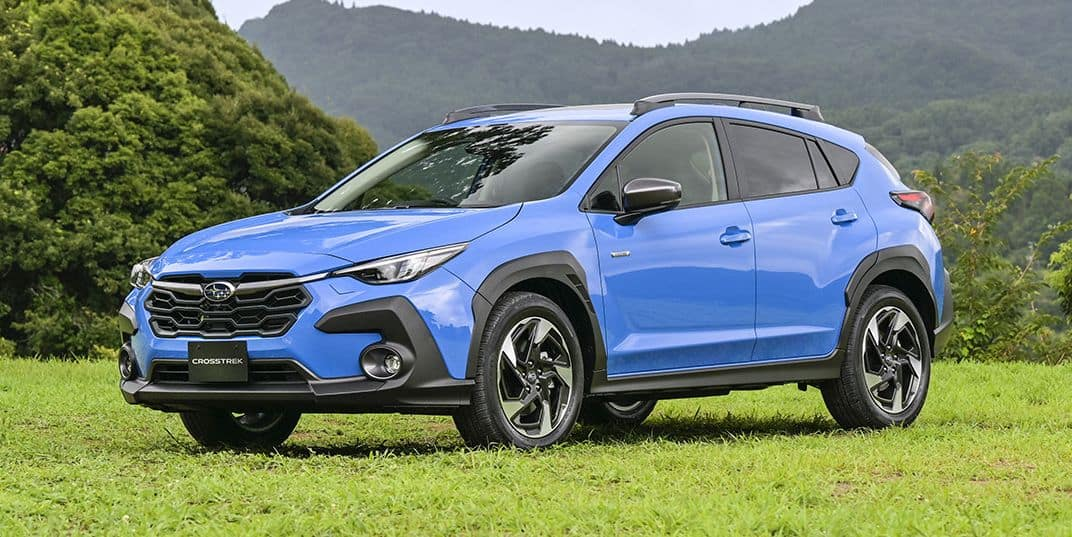

'------------------------------------------------------------------------------------------'

'→ /app/data/crosstrek1.png  (score 0.9247)'

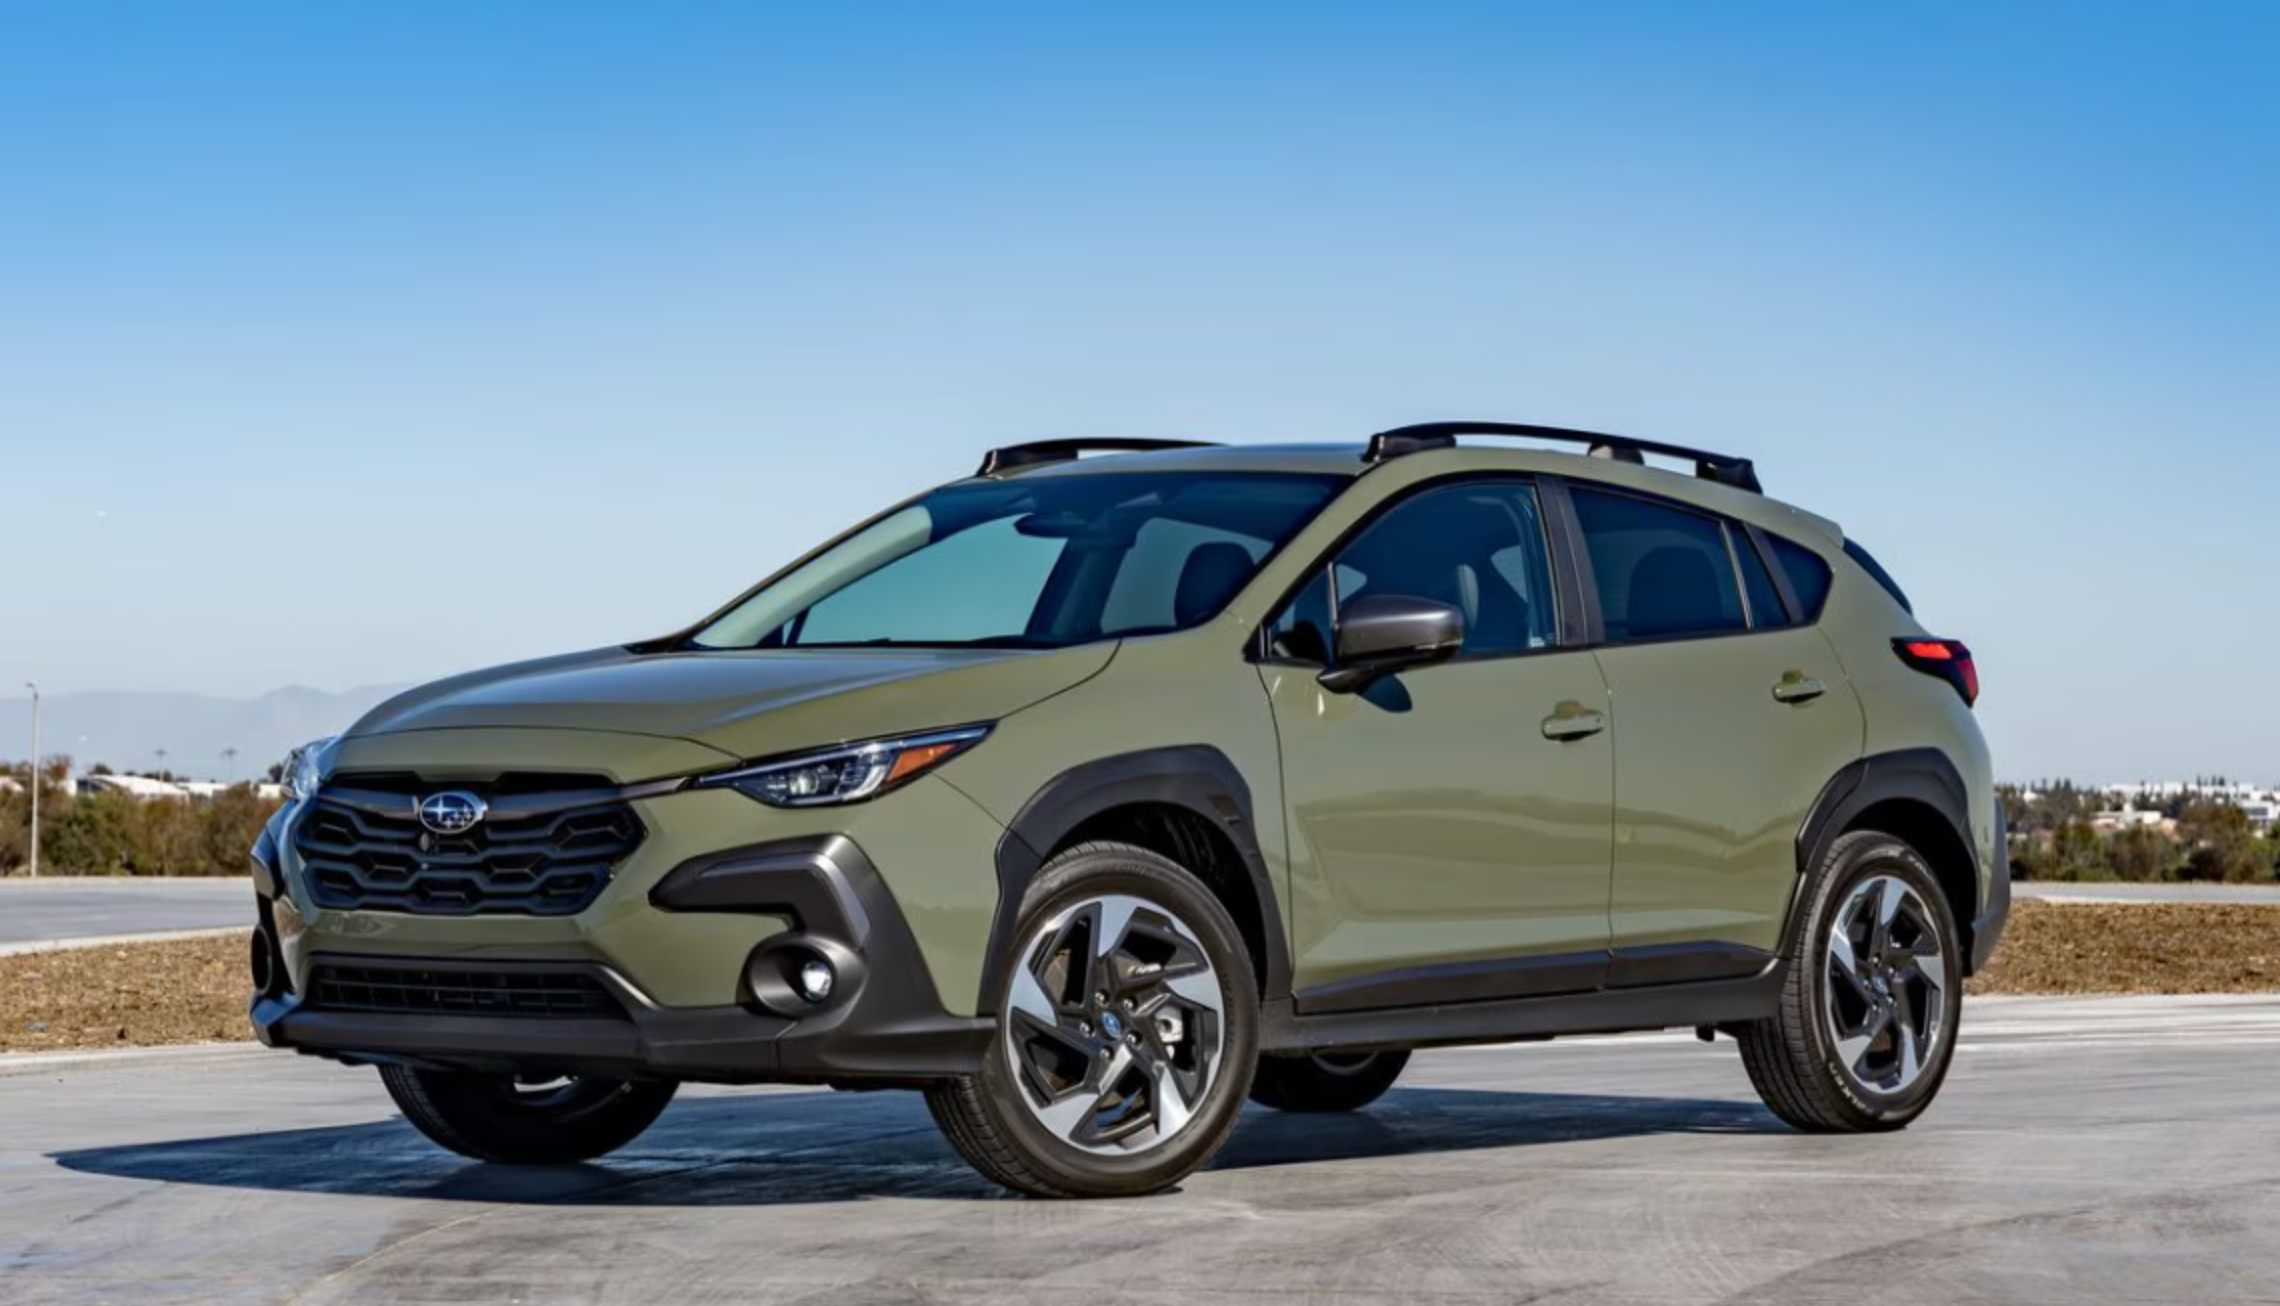

'------------------------------------------------------------------------------------------'

'→ /app/data/crosstrek2.png  (score 0.9122)'

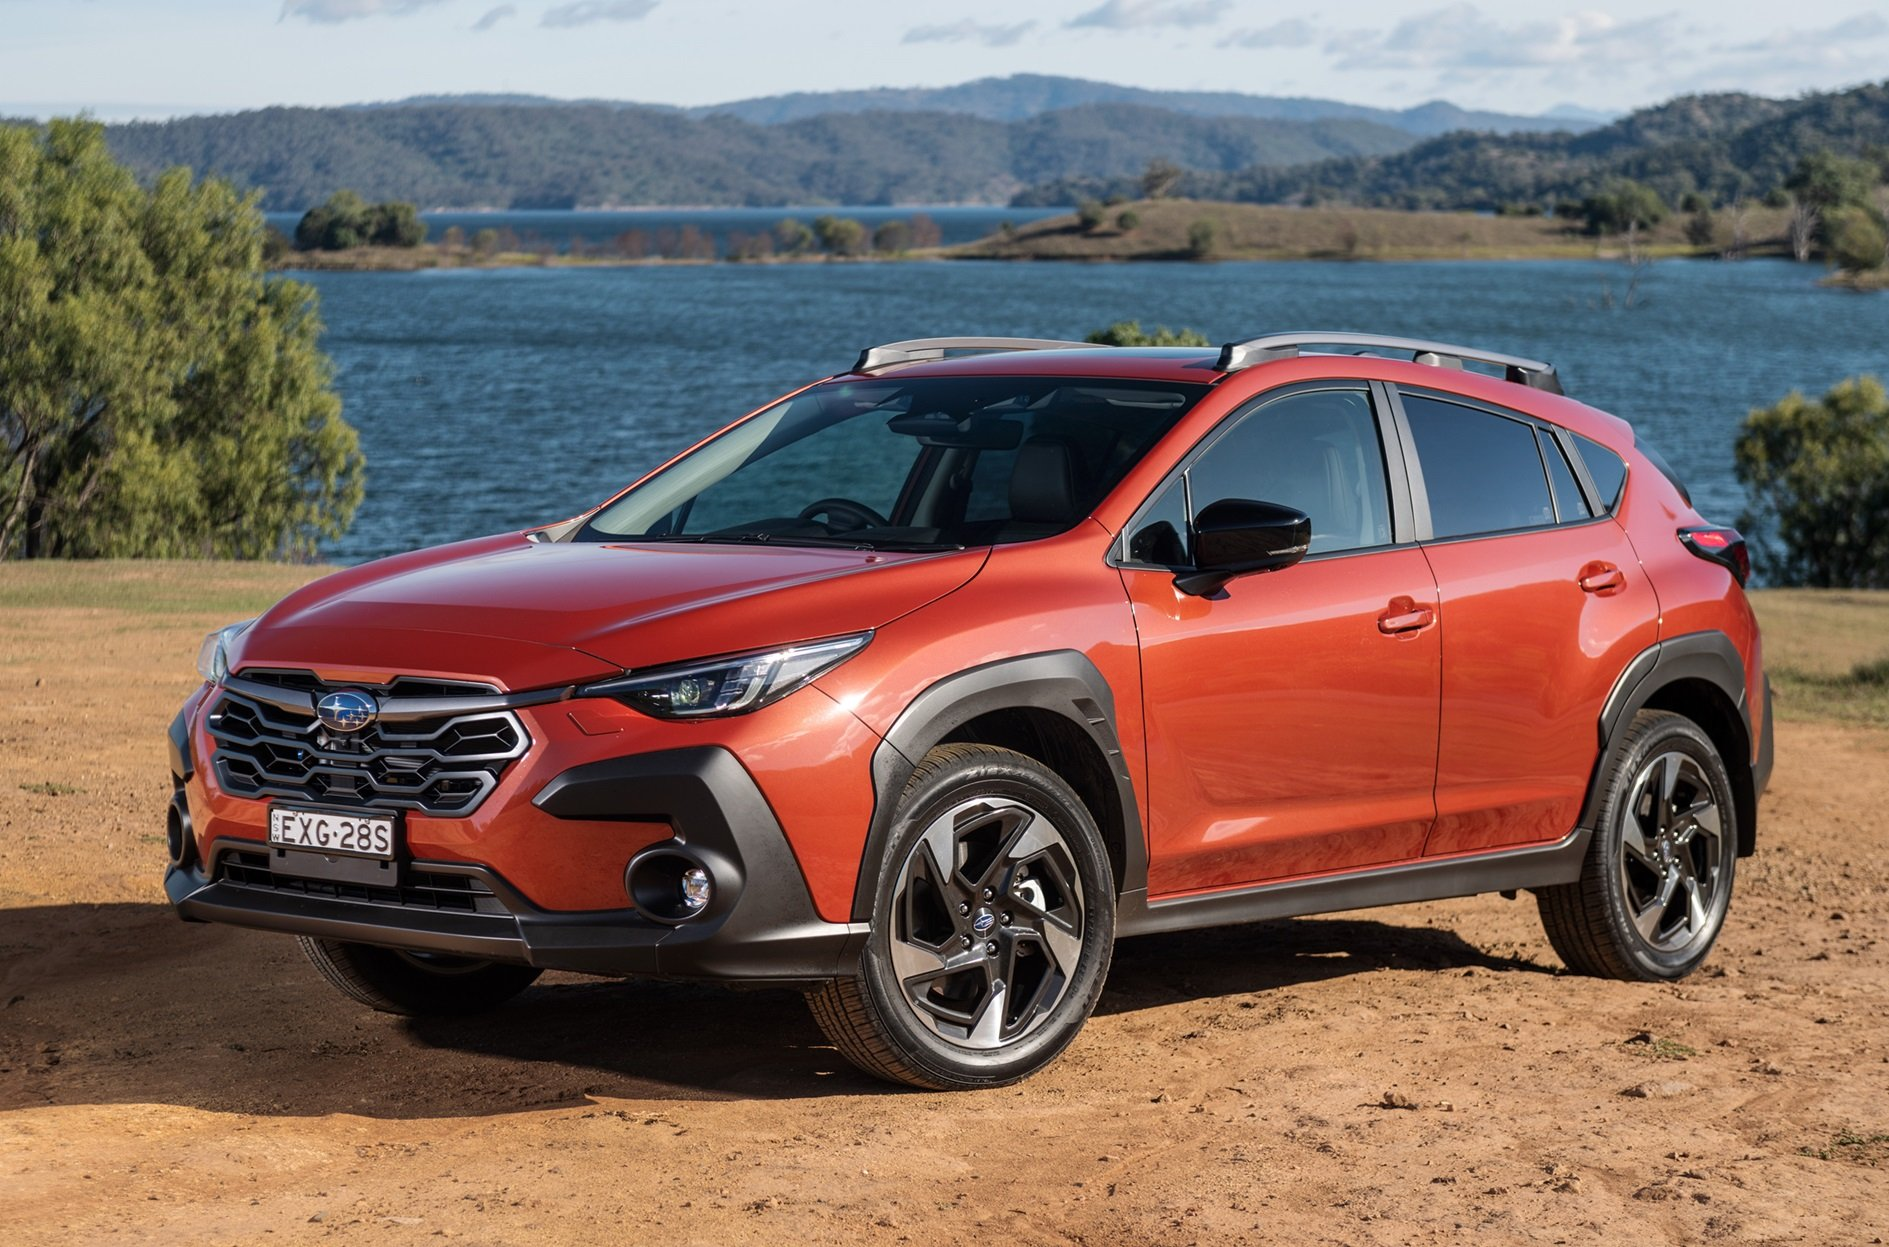

'------------------------------------------------------------------------------------------'

'→ /app/data/crosstrek4.png  (score 0.8772)'

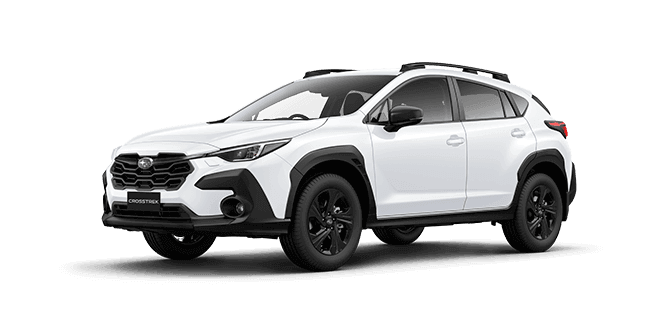

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score -340282346638528859811704183484516925440.0000)'

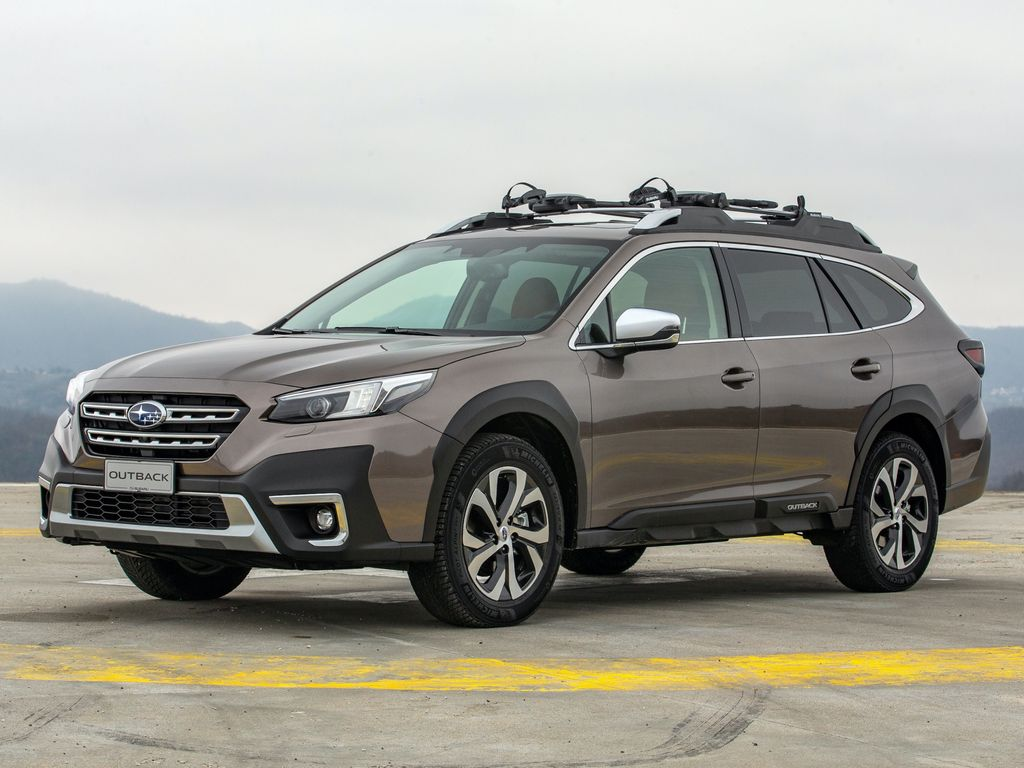

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score -340282346638528859811704183484516925440.0000)'

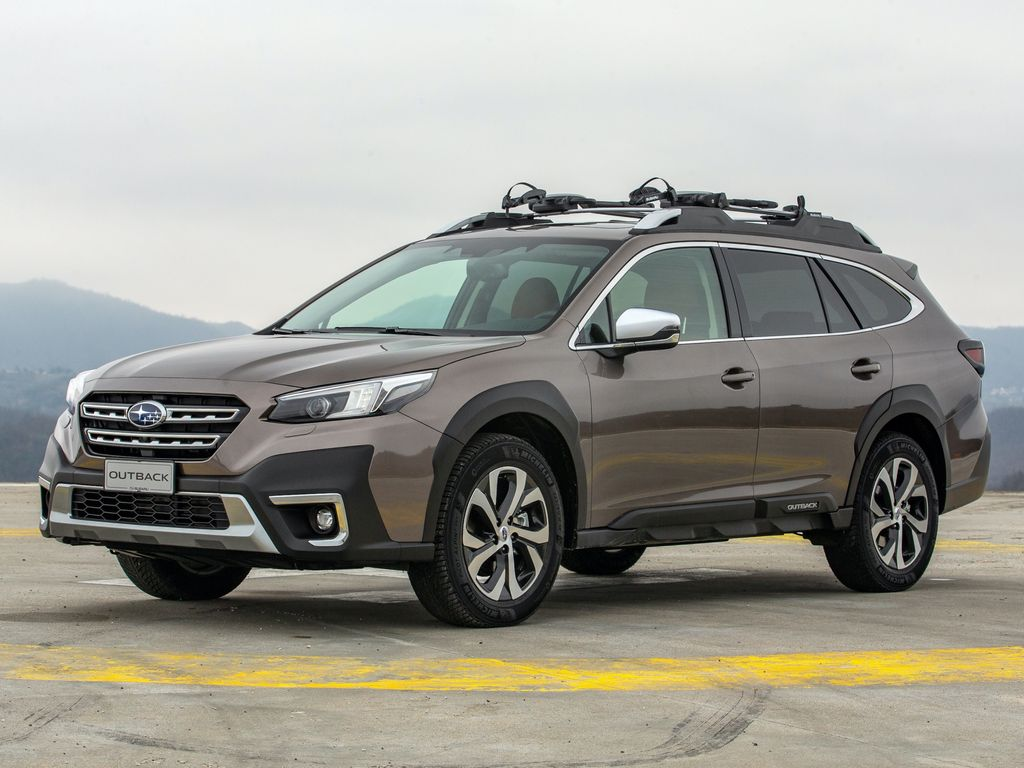

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score -340282346638528859811704183484516925440.0000)'

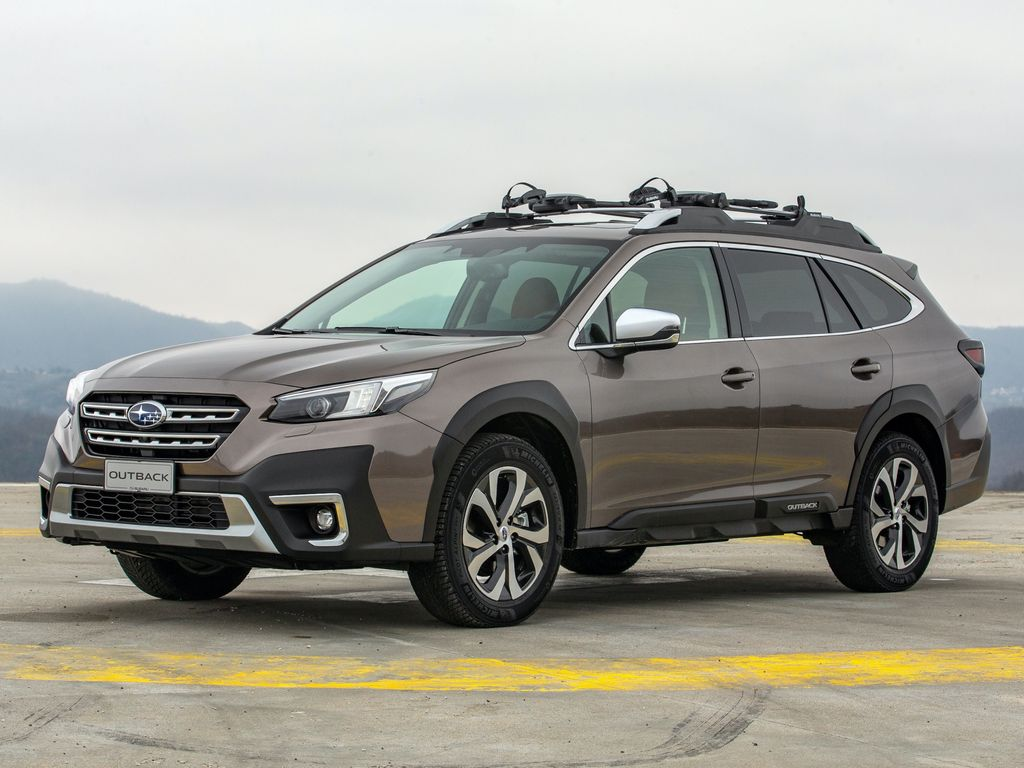

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score -340282346638528859811704183484516925440.0000)'

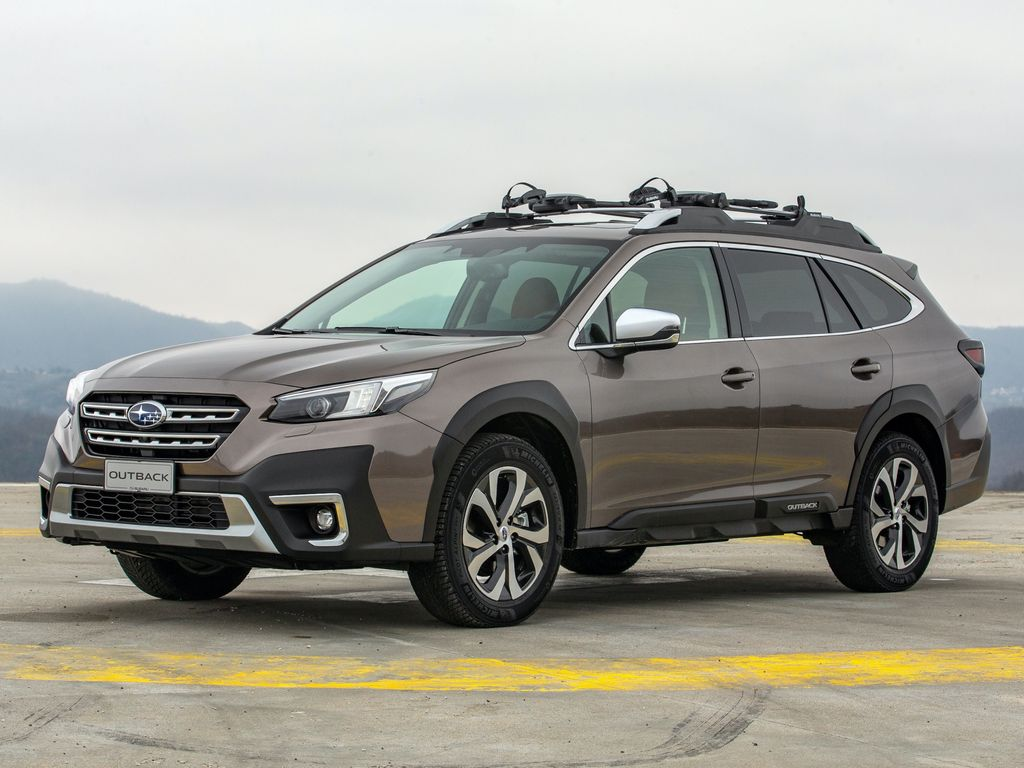

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score -340282346638528859811704183484516925440.0000)'

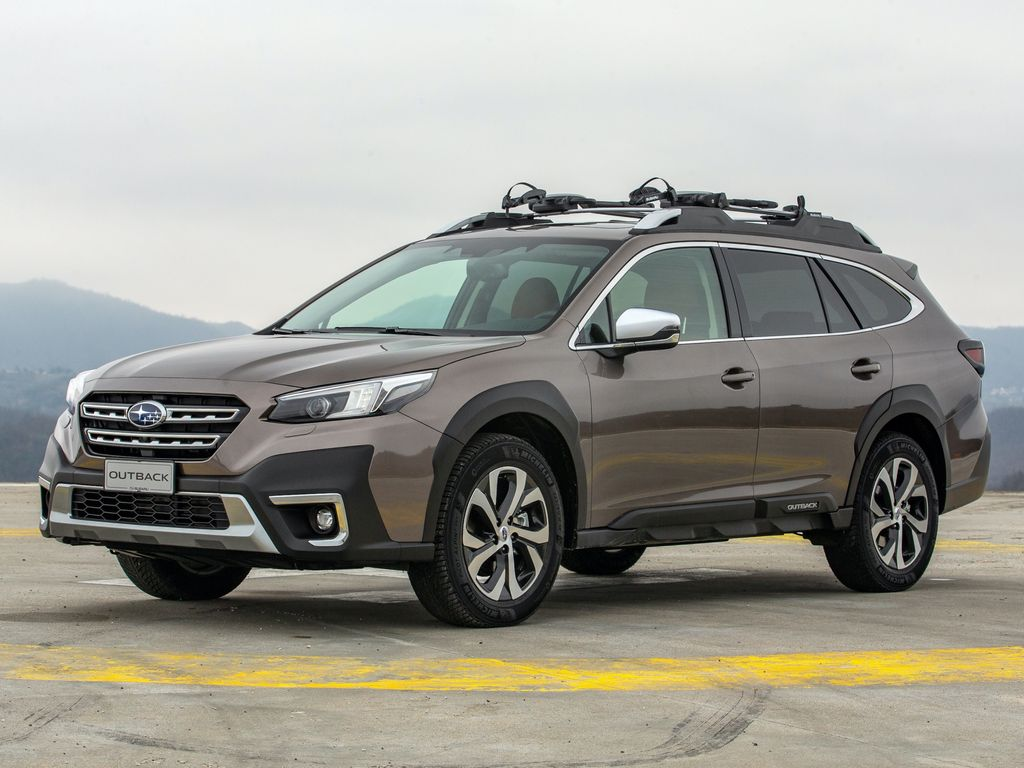

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score -340282346638528859811704183484516925440.0000)'

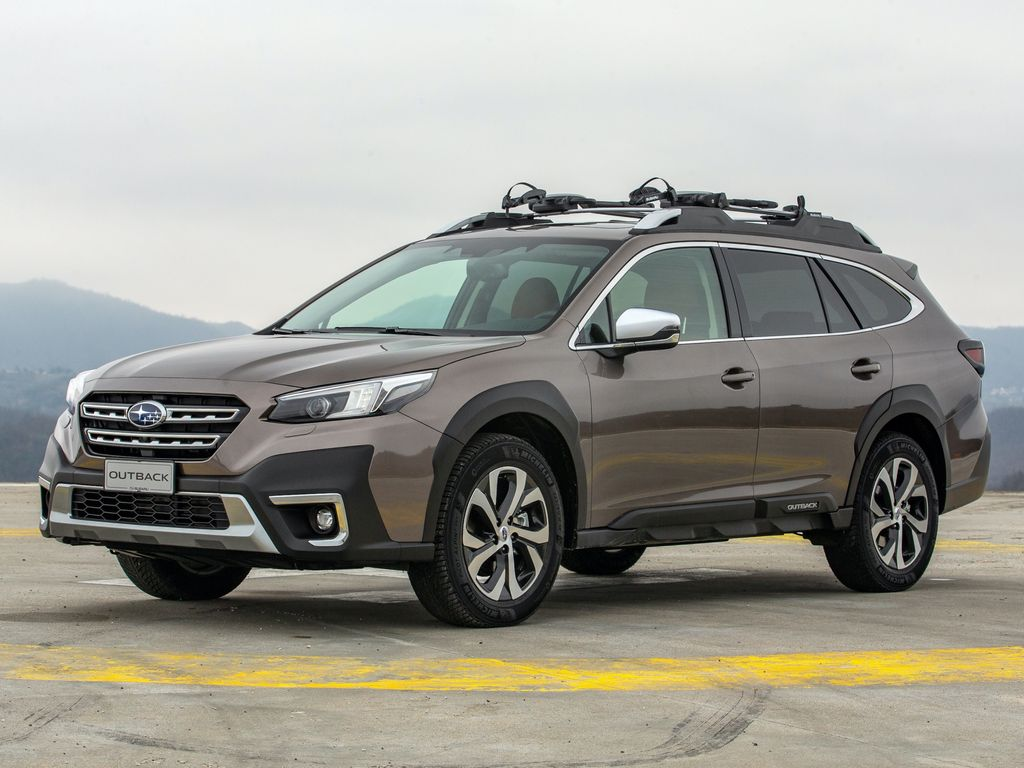

'------------------------------------------------------------------------------------------'

'→ /app/data/outback2.jpeg  (score -340282346638528859811704183484516925440.0000)'

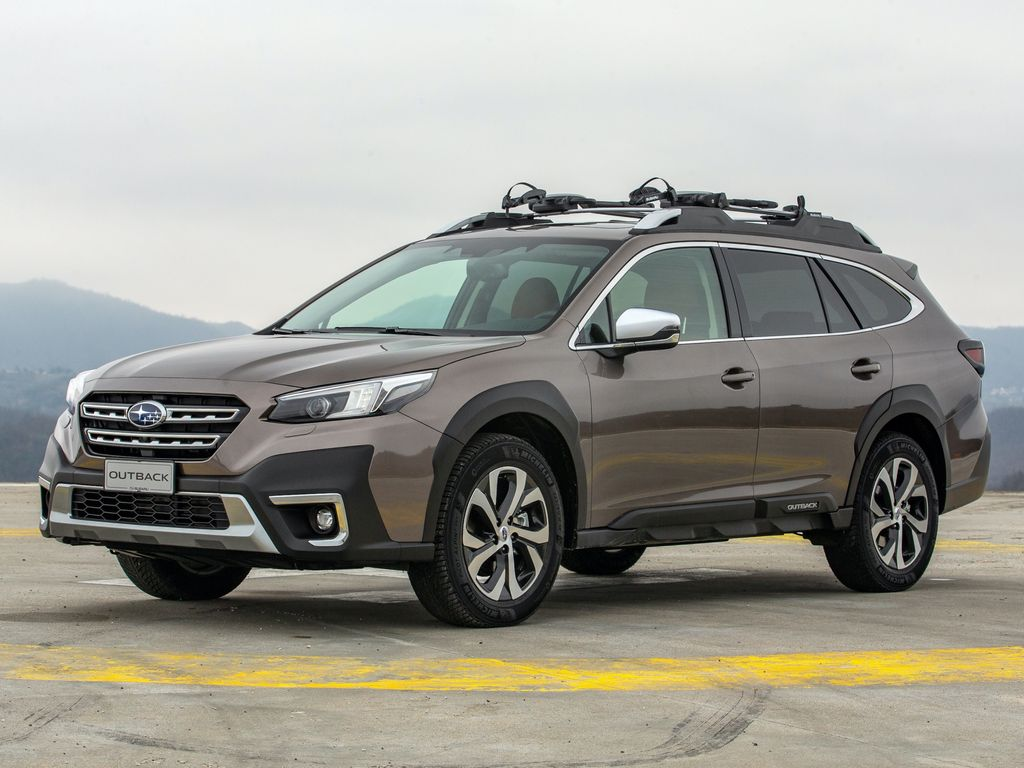

'------------------------------------------------------------------------------------------'

In [5]:
import ipywidgets as widgets  # pip install ipywidgets
from IPython.display import display, Image as IPyImage

def search(image_path: str, k: int = 13):
    """Return top-k similar file paths for an existing image in the index."""
    # Ensure the query image exists in the indexed paths
    try:
        idx = id_to_path.index(str(Path(image_path).resolve()))
    except ValueError:
        print(f"Image path '{image_path}' not found in indexed set.")
        return

    # Use its corresponding vector (already embedded)
    q_vec = vecs_np[idx].reshape(1, -1)

    # Perform search
    D, I = index.search(q_vec, k)

    print("\nTop matches:")
    for rank, (dist, i) in enumerate(zip(D[0], I[0]), 1):
        display(f"→ {id_to_path[i]}  (score {dist:.4f})")
        display(IPyImage(id_to_path[i], width=400))
        display("------------------------------------------------------------------------------------------")
        display()



# Create input field and button
path_input = widgets.Text(
    value='./data/outback1.jpeg',
    placeholder='Enter image file name',
    description='Image file name:',
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)
run_button = widgets.Button(description="🔍 Search")

# Display widgets
display(path_input, run_button)

# Define button click behavior
def on_search_click(b):
    search(path_input.value)

# Connect button to action
run_button.on_click(on_search_click)